# Notebook 12: Unified Comparison Dashboard

**Purpose**: Aggregate all results and provide comprehensive analysis across Classical, Neural, and QML paradigms.

**Inputs**:
- `classical_metrics.csv`
- `neural_metrics.csv`
- `qml_metrics.csv`

**Outputs**:
- Final dashboard visualizations → `charts/`
- Summary report

---

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
import json

# Paths
BASE_DIR = Path('.').resolve().parent
RESULTS_DIR = BASE_DIR / 'results'
CHARTS_DIR = BASE_DIR / 'charts'
CHARTS_DIR.mkdir(exist_ok=True)

# Style
plt.style.use('seaborn-v0_8-whitegrid')
COLORS = {
    'Classical': '#3498db',
    'Neural': '#e74c3c',
    'QML': '#9b59b6'
}

print(f"Charts will be saved to: {CHARTS_DIR}")

Charts will be saved to: C:\Users\mostr\OneDrive\Documents\GitHub\Proj\Anomaly-detection-in-finance-using-QML\charts


In [3]:
# Load all metrics
classical_df = pd.read_csv(RESULTS_DIR / 'classical_metrics.csv')
neural_df = pd.read_csv(RESULTS_DIR / 'neural_metrics.csv')
qml_df = pd.read_csv(RESULTS_DIR / 'qml_metrics.csv')

classical_df['category'] = 'Classical'
neural_df['category'] = 'Neural'
qml_df['category'] = 'QML'

# Combine all
all_df = pd.concat([classical_df, neural_df, qml_df], ignore_index=True)

print(f"Total models: {len(all_df)}")
print(f"  Classical: {len(classical_df)}")
print(f"  Neural: {len(neural_df)}")
print(f"  QML: {len(qml_df)}")

Total models: 18
  Classical: 8
  Neural: 5
  QML: 5


## 1. Complete Metrics Table

In [4]:
# Display complete results
display_cols = ['model', 'category', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc', 'train_time']
display_df = all_df[display_cols].sort_values('f1_score', ascending=False)

print("\n" + "="*100)
print("COMPLETE MODEL COMPARISON - SORTED BY F1 SCORE")
print("="*100)
print(display_df.to_string(index=False))


COMPLETE MODEL COMPARISON - SORTED BY F1 SCORE
                model  category  accuracy  precision  recall  f1_score  roc_auc  train_time
             Deep_MLP    Neural    0.9950   1.000000    0.90  0.947368 0.946447    1.977893
        Random_Forest Classical    0.9950   1.000000    0.90  0.947368 0.998816    0.501200
              SVM_RBF Classical    0.9900   0.900000    0.90  0.900000 0.904211    0.388940
           SVM_Linear Classical    0.9850   0.818182    0.90  0.857143 0.909934  120.214205
        Classical_MLP Classical    0.9850   0.937500    0.75  0.833333 0.947763    0.266343
  Logistic_Regression Classical    0.9750   0.692308    0.90  0.782609 0.911382    0.077424
     Deep_Autoencoder    Neural    0.9325   0.370370    0.50  0.425532 0.896053   11.250247
            Deep_OCNN    Neural    0.9150   0.266667    0.40  0.320000 0.821184    2.723756
                  GMM Classical    0.9250   0.291667    0.35  0.318182 0.878026    0.068837
Classical_Autoencoder Classical 

## 2. Metric-wise Bar Plots

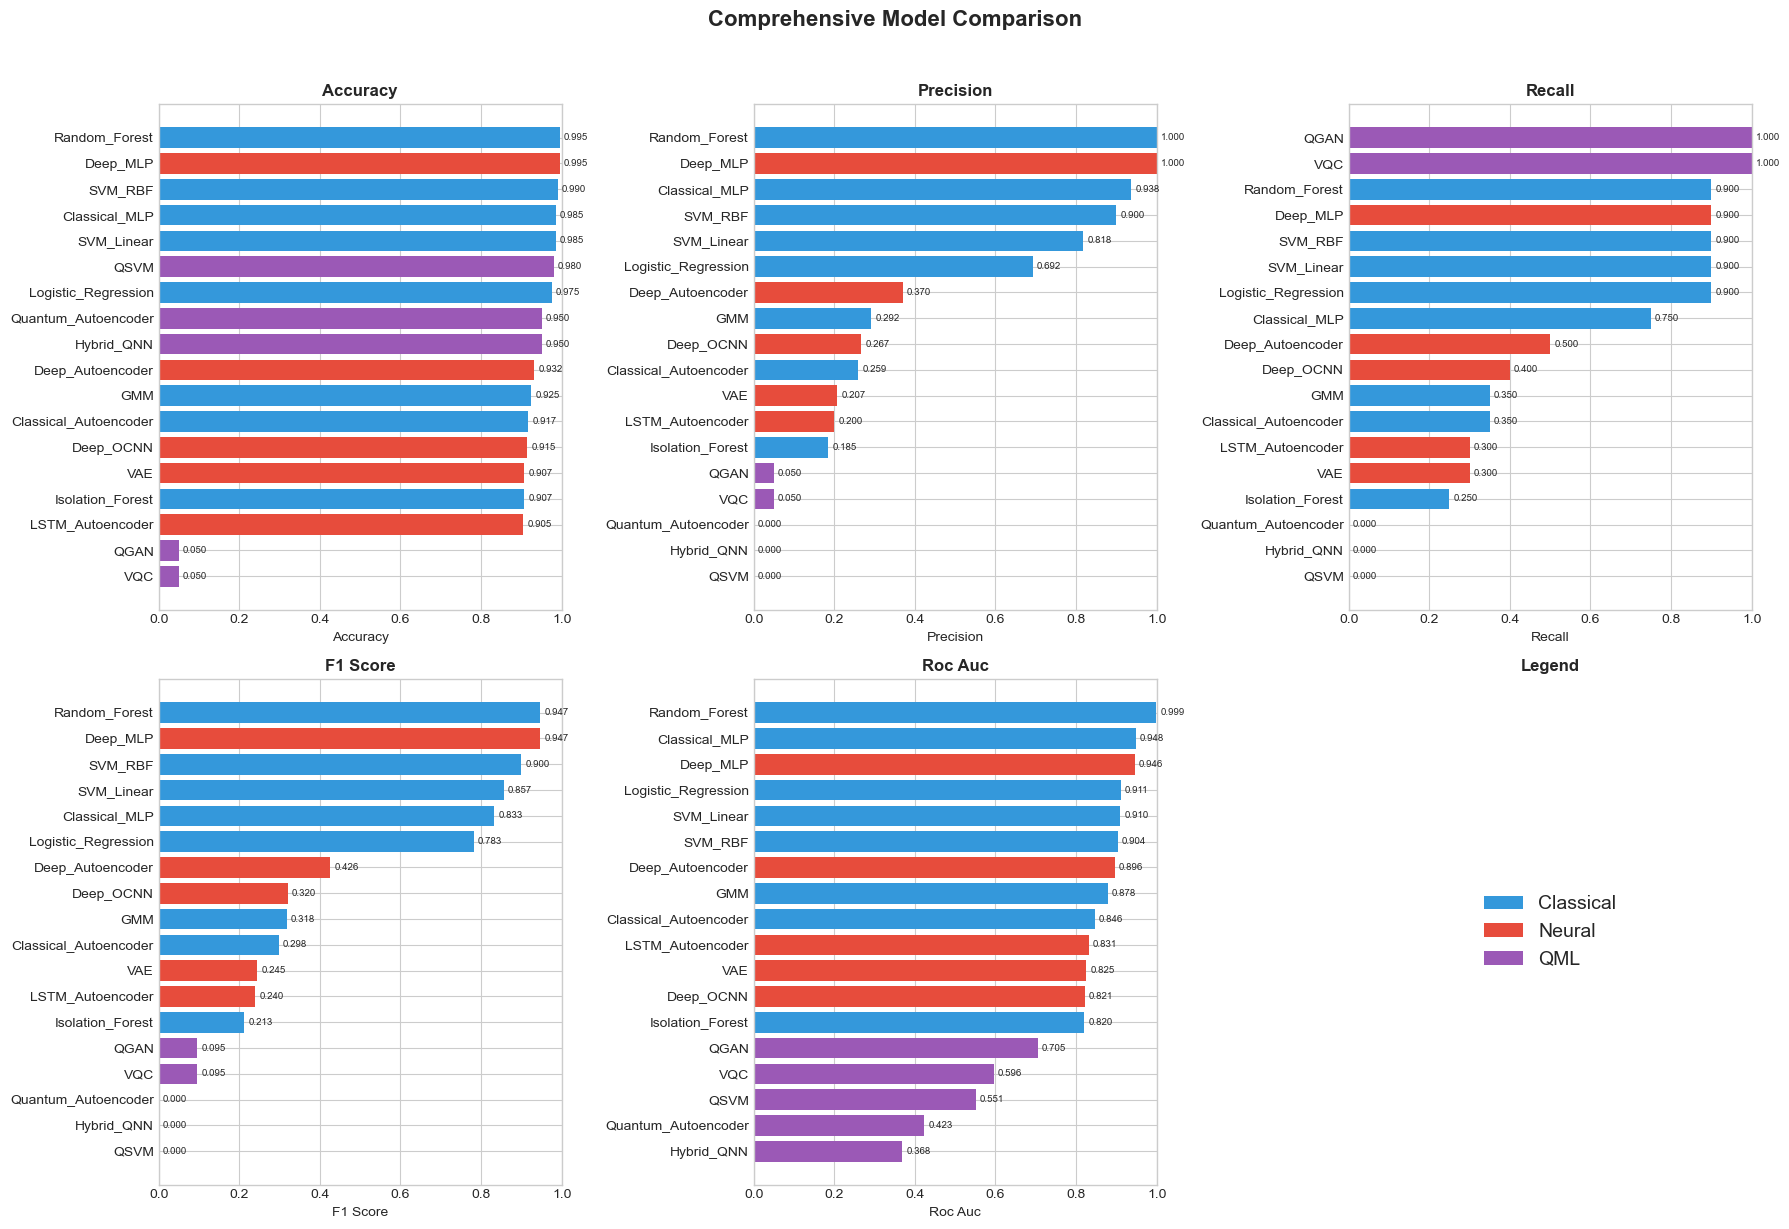

✅ Saved: unified_metrics_comparison.png


In [5]:
# Comprehensive metric comparison
metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    ax = axes[i]
    data = all_df.sort_values(metric, ascending=True)
    colors_list = [COLORS[c] for c in data['category']]
    
    bars = ax.barh(data['model'], data[metric], color=colors_list)
    ax.set_xlabel(metric.replace('_', ' ').title())
    ax.set_title(f'{metric.replace("_", " ").title()}', fontsize=12, fontweight='bold')
    ax.set_xlim([0, 1])
    
    # Add value labels
    for bar, val in zip(bars, data[metric]):
        if pd.notna(val):
            ax.text(val + 0.01, bar.get_y() + bar.get_height()/2, 
                   f'{val:.3f}', va='center', fontsize=7)

# Legend
legend_elements = [Patch(facecolor=color, label=cat) for cat, color in COLORS.items()]
axes[-1].legend(handles=legend_elements, loc='center', fontsize=14)
axes[-1].set_title('Legend', fontsize=12, fontweight='bold')
axes[-1].axis('off')

plt.suptitle('Comprehensive Model Comparison', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(CHARTS_DIR / 'unified_metrics_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"✅ Saved: unified_metrics_comparison.png")

## 3. F1 Score Comparison

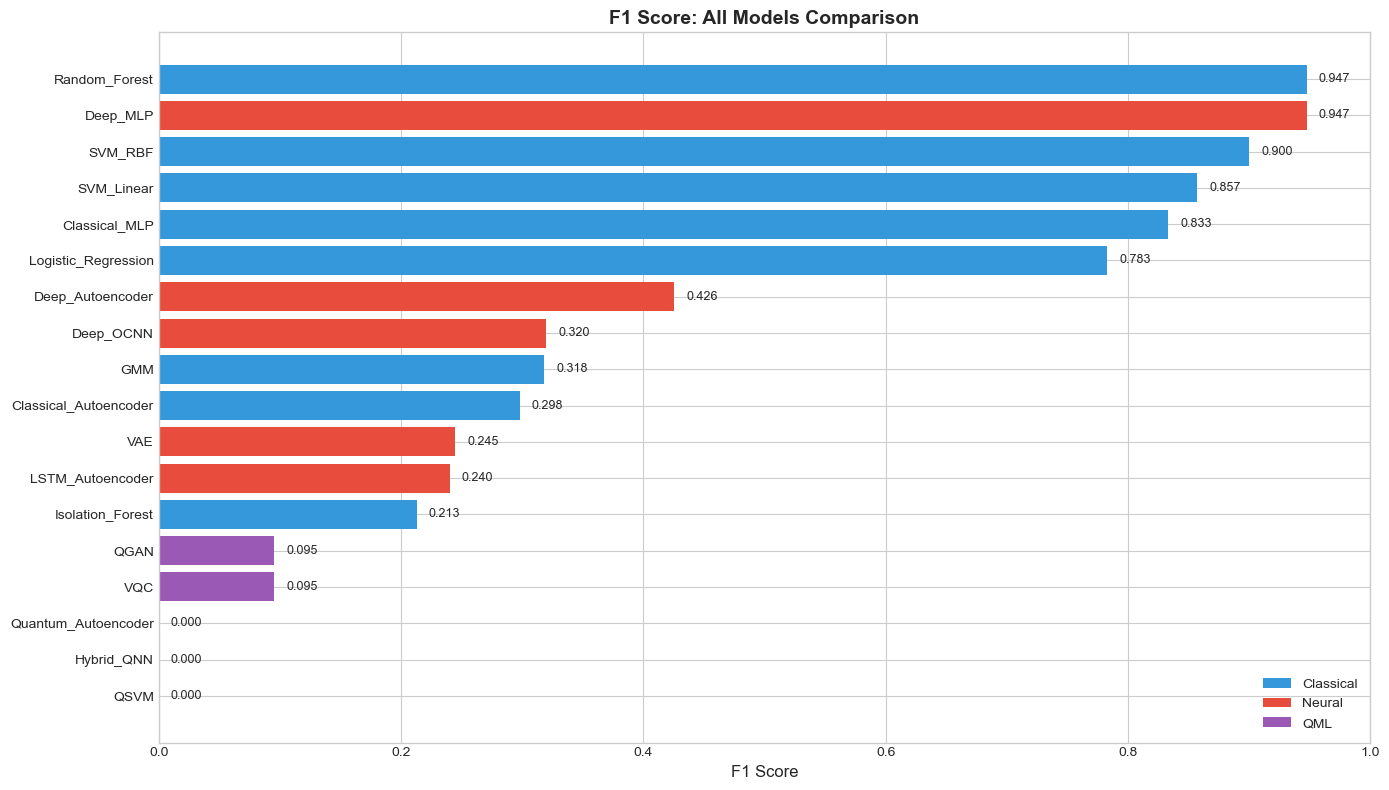

✅ Saved: unified_f1_score.png


In [6]:
# F1 Score comparison - all models
fig, ax = plt.subplots(figsize=(14, 8))

data = all_df.sort_values('f1_score', ascending=True)
colors_list = [COLORS[c] for c in data['category']]

bars = ax.barh(data['model'], data['f1_score'], color=colors_list)
ax.set_xlabel('F1 Score', fontsize=12)
ax.set_title('F1 Score: All Models Comparison', fontsize=14, fontweight='bold')
ax.set_xlim([0, 1])

for bar, val in zip(bars, data['f1_score']):
    ax.text(val + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.3f}', va='center', fontsize=9)

# Add legend
legend_elements = [Patch(facecolor=color, label=cat) for cat, color in COLORS.items()]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig(CHARTS_DIR / 'unified_f1_score.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"✅ Saved: unified_f1_score.png")

## 4. ROC-AUC Comparison

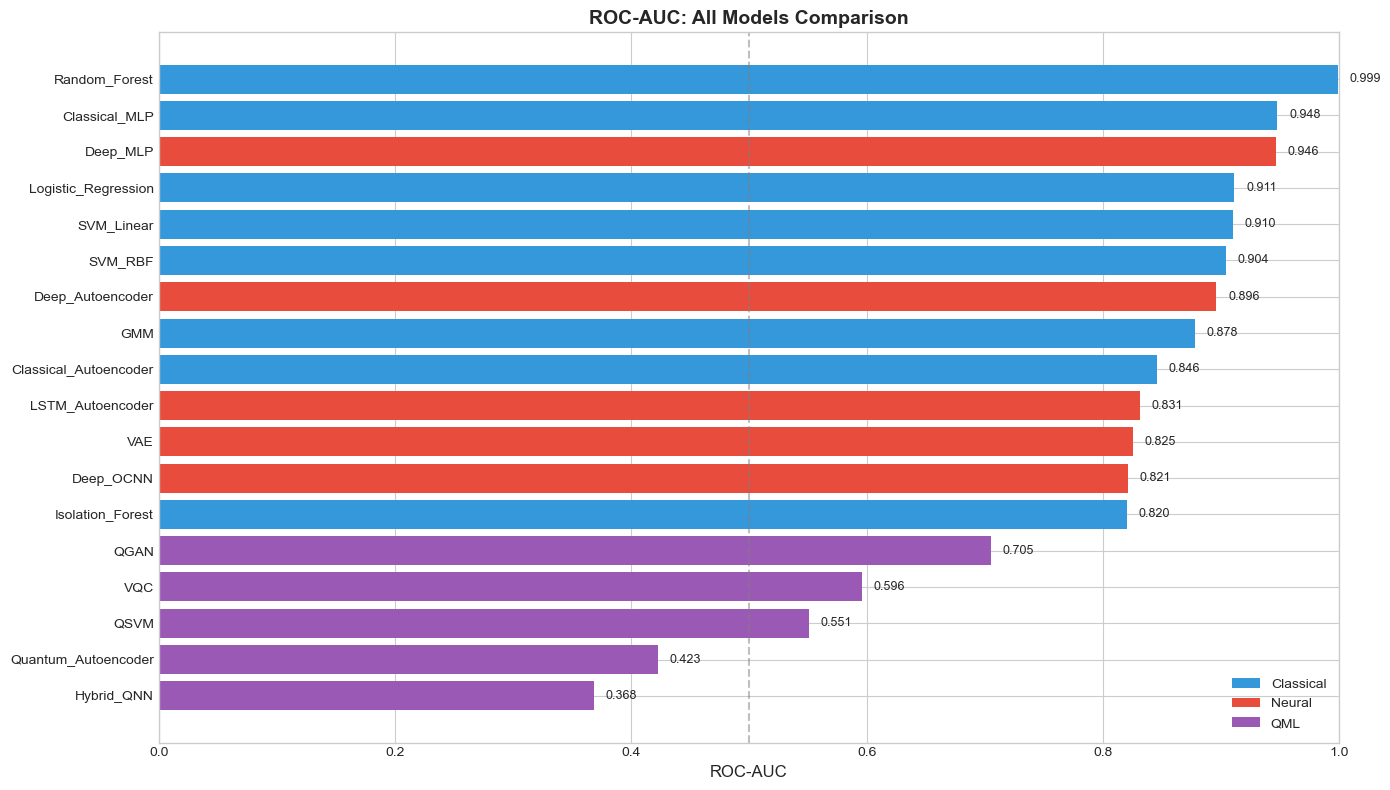

✅ Saved: unified_roc_auc.png


In [7]:
# ROC-AUC comparison - all models
fig, ax = plt.subplots(figsize=(14, 8))

data = all_df.sort_values('roc_auc', ascending=True)
colors_list = [COLORS[c] for c in data['category']]

bars = ax.barh(data['model'], data['roc_auc'], color=colors_list)
ax.set_xlabel('ROC-AUC', fontsize=12)
ax.set_title('ROC-AUC: All Models Comparison', fontsize=14, fontweight='bold')
ax.set_xlim([0, 1])
ax.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5, label='Random')

for bar, val in zip(bars, data['roc_auc']):
    ax.text(val + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.3f}', va='center', fontsize=9)

legend_elements = [Patch(facecolor=color, label=cat) for cat, color in COLORS.items()]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig(CHARTS_DIR / 'unified_roc_auc.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"✅ Saved: unified_roc_auc.png")

## 5. Runtime Comparison

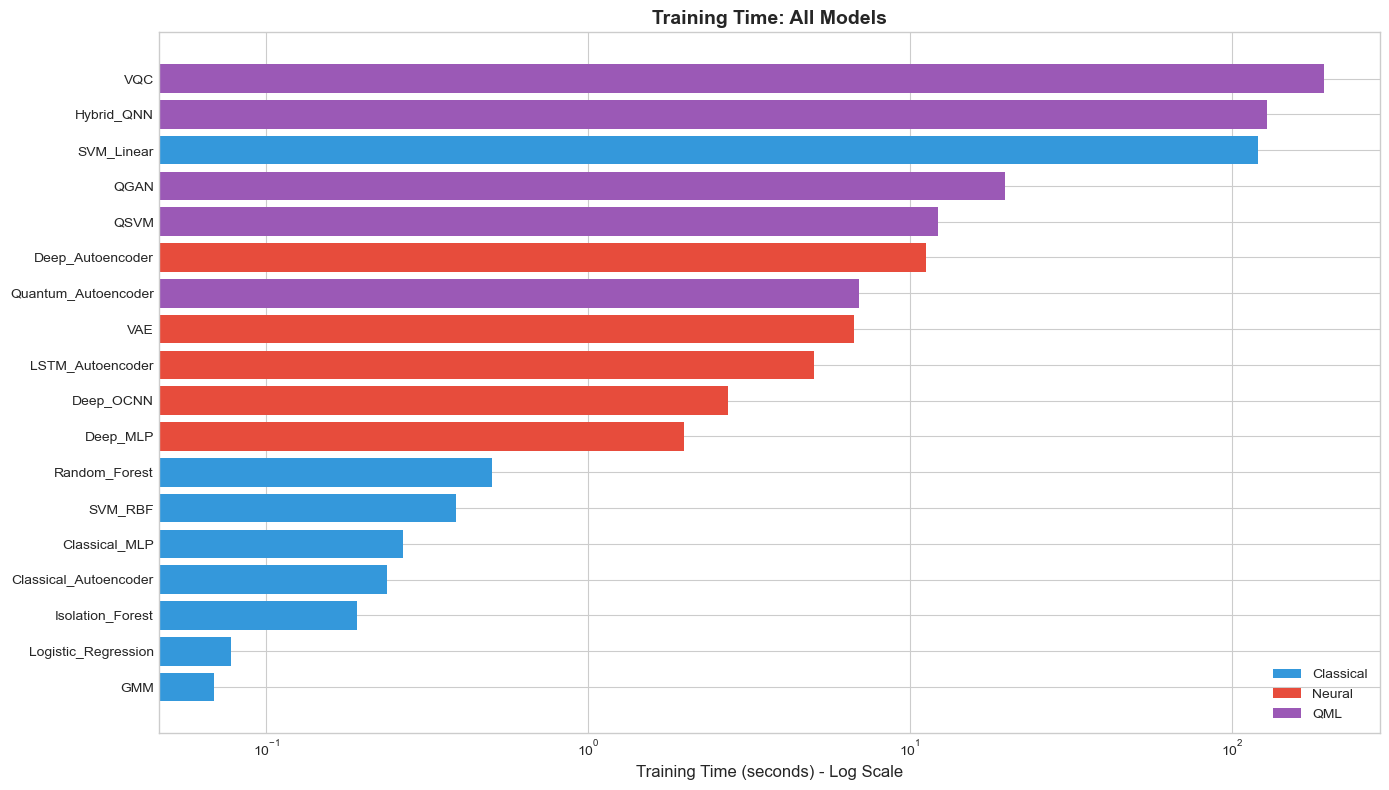

✅ Saved: unified_training_time.png


In [8]:
# Training time comparison
fig, ax = plt.subplots(figsize=(14, 8))

data = all_df.sort_values('train_time', ascending=True)
colors_list = [COLORS[c] for c in data['category']]

ax.barh(data['model'], data['train_time'], color=colors_list)
ax.set_xlabel('Training Time (seconds) - Log Scale', fontsize=12)
ax.set_xscale('log')
ax.set_title('Training Time: All Models', fontsize=14, fontweight='bold')

legend_elements = [Patch(facecolor=color, label=cat) for cat, color in COLORS.items()]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig(CHARTS_DIR / 'unified_training_time.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"✅ Saved: unified_training_time.png")

## 6. Radar Plot (Best Models)

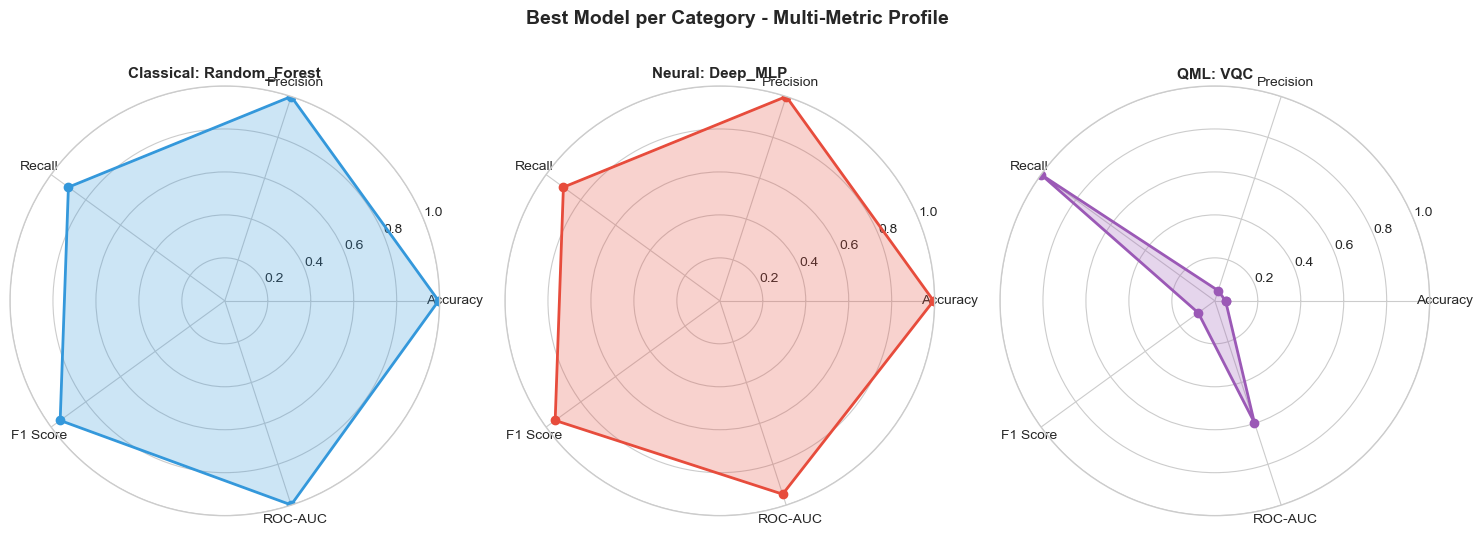

✅ Saved: unified_radar_best_models.png


In [9]:
# Radar plot for top models from each category
categories = ['Classical', 'Neural', 'QML']

def radar_plot(ax, metrics_values, labels, title, color):
    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    metrics_values = metrics_values + [metrics_values[0]]
    angles = angles + [angles[0]]
    
    ax.plot(angles, metrics_values, 'o-', linewidth=2, color=color)
    ax.fill(angles, metrics_values, alpha=0.25, color=color)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.set_ylim([0, 1])

# Get best model from each category
best_models = {}
for cat in categories:
    cat_data = all_df[all_df['category'] == cat]
    best_idx = cat_data['f1_score'].idxmax()
    best_models[cat] = all_df.loc[best_idx]

radar_metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']
radar_labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC']

fig, axes = plt.subplots(1, 3, figsize=(15, 5), subplot_kw=dict(polar=True))

for i, (cat, model_data) in enumerate(best_models.items()):
    values = [model_data[m] for m in radar_metrics]
    radar_plot(axes[i], values, radar_labels, 
               f'{cat}: {model_data["model"]}', COLORS[cat])

plt.suptitle('Best Model per Category - Multi-Metric Profile', fontsize=14, fontweight='bold', y=1.05)
plt.tight_layout()
plt.savefig(CHARTS_DIR / 'unified_radar_best_models.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"✅ Saved: unified_radar_best_models.png")

## 7. Best Model per Metric

In [10]:

print("BEST MODEL PER METRIC - ALL CATEGORIES")


metrics_to_compare = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']
best_per_metric = []

for metric in metrics_to_compare:
    # Best from each category
    best_classical = classical_df.loc[classical_df[metric].idxmax()]
    best_neural = neural_df.loc[neural_df[metric].idxmax()]
    best_qml = qml_df.loc[qml_df[metric].idxmax()]
    
    # Overall best
    best_idx = all_df[metric].idxmax()
    best_overall = all_df.loc[best_idx]
    
    best_per_metric.append({
        'Metric': metric.replace('_', ' ').title(),
        'Best Classical': f"{best_classical['model']} ({best_classical[metric]:.4f})",
        'Best Neural': f"{best_neural['model']} ({best_neural[metric]:.4f})",
        'Best QML': f"{best_qml['model']} ({best_qml[metric]:.4f})",
        'Overall Winner': f"{best_overall['category']}: {best_overall['model']}"
    })
    
    print(f"\n{metric.replace('_', ' ').title()}:")
    print(f"  Classical: {best_classical['model']} = {best_classical[metric]:.4f}")
    print(f"  Neural: {best_neural['model']} = {best_neural[metric]:.4f}")
    print(f"  QML: {best_qml['model']} = {best_qml[metric]:.4f}")
    print(f"  🏆 OVERALL WINNER: {best_overall['category']} ({best_overall['model']})")

# Fastest model (training time - lower is better)
print(f"\nTraining Time (lower is better):")
fastest_classical = classical_df.loc[classical_df['train_time'].idxmin()]
fastest_neural = neural_df.loc[neural_df['train_time'].idxmin()]
fastest_qml = qml_df.loc[qml_df['train_time'].idxmin()]
fastest_overall = all_df.loc[all_df['train_time'].idxmin()]

print(f"  Classical: {fastest_classical['model']} = {fastest_classical['train_time']:.4f}s")
print(f"  Neural: {fastest_neural['model']} = {fastest_neural['train_time']:.4f}s")
print(f"  QML: {fastest_qml['model']} = {fastest_qml['train_time']:.4f}s")
print(f"  🏆 FASTEST: {fastest_overall['category']} ({fastest_overall['model']})")

BEST MODEL PER METRIC - ALL CATEGORIES

Accuracy:
  Classical: Random_Forest = 0.9950
  Neural: Deep_MLP = 0.9950
  QML: QSVM = 0.9800
  🏆 OVERALL WINNER: Classical (Random_Forest)

Precision:
  Classical: Random_Forest = 1.0000
  Neural: Deep_MLP = 1.0000
  QML: VQC = 0.0500
  🏆 OVERALL WINNER: Classical (Random_Forest)

Recall:
  Classical: SVM_Linear = 0.9000
  Neural: Deep_MLP = 0.9000
  QML: VQC = 1.0000
  🏆 OVERALL WINNER: QML (VQC)

F1 Score:
  Classical: Random_Forest = 0.9474
  Neural: Deep_MLP = 0.9474
  QML: VQC = 0.0952
  🏆 OVERALL WINNER: Classical (Random_Forest)

Roc Auc:
  Classical: Random_Forest = 0.9988
  Neural: Deep_MLP = 0.9464
  QML: QGAN = 0.7053
  🏆 OVERALL WINNER: Classical (Random_Forest)

Training Time (lower is better):
  Classical: GMM = 0.0688s
  Neural: Deep_MLP = 1.9779s
  QML: Quantum_Autoencoder = 6.9283s
  🏆 FASTEST: Classical (GMM)


In [11]:
# Summary table
best_df = pd.DataFrame(best_per_metric)
print("\n" + "="*80)
print("SUMMARY TABLE - BEST MODEL PER METRIC")
print("="*80)
print(best_df.to_string(index=False))

best_df.to_csv(RESULTS_DIR / 'unified_best_per_metric.csv', index=False)
print(f"\n✅ Saved: unified_best_per_metric.csv")


SUMMARY TABLE - BEST MODEL PER METRIC
   Metric         Best Classical       Best Neural      Best QML           Overall Winner
 Accuracy Random_Forest (0.9950) Deep_MLP (0.9950) QSVM (0.9800) Classical: Random_Forest
Precision Random_Forest (1.0000) Deep_MLP (1.0000)  VQC (0.0500) Classical: Random_Forest
   Recall    SVM_Linear (0.9000) Deep_MLP (0.9000)  VQC (1.0000)                 QML: VQC
 F1 Score Random_Forest (0.9474) Deep_MLP (0.9474)  VQC (0.0952) Classical: Random_Forest
  Roc Auc Random_Forest (0.9988) Deep_MLP (0.9464) QGAN (0.7053) Classical: Random_Forest

✅ Saved: unified_best_per_metric.csv


## 8. Final Analysis & Conclusions

In [12]:
print("\n" + "="*80)
print("FINAL ANALYSIS & CONCLUSIONS")
print("="*80)

print("\n🎯 KEY FINDINGS")
print("-" * 40)

# Best overall
best_f1_overall = all_df.loc[all_df['f1_score'].idxmax()]
best_auc_overall = all_df.loc[all_df['roc_auc'].idxmax()]
fastest_overall = all_df.loc[all_df['train_time'].idxmin()]

print(f"\n🥇 BEST F1 SCORE: {best_f1_overall['model']} ({best_f1_overall['category']})")
print(f"   F1 = {best_f1_overall['f1_score']:.4f}")

print(f"\n🥇 BEST ROC-AUC: {best_auc_overall['model']} ({best_auc_overall['category']})")
print(f"   AUC = {best_auc_overall['roc_auc']:.4f}")

print(f"\n⚡ FASTEST MODEL: {fastest_overall['model']} ({fastest_overall['category']})")
print(f"   Time = {fastest_overall['train_time']:.4f}s")

# Best per category
print("\n" + "-" * 40)
print("BEST MODEL PER CATEGORY:")
for cat in categories:
    cat_best = best_models[cat]
    print(f"  {cat}: {cat_best['model']} (F1: {cat_best['f1_score']:.4f})")


FINAL ANALYSIS & CONCLUSIONS

🎯 KEY FINDINGS
----------------------------------------

🥇 BEST F1 SCORE: Random_Forest (Classical)
   F1 = 0.9474

🥇 BEST ROC-AUC: Random_Forest (Classical)
   AUC = 0.9988

⚡ FASTEST MODEL: GMM (Classical)
   Time = 0.0688s

----------------------------------------
BEST MODEL PER CATEGORY:
  Classical: Random_Forest (F1: 0.9474)
  Neural: Deep_MLP (F1: 0.9474)
  QML: VQC (F1: 0.0952)


In [13]:
print("\n" + "="*80)
print("HONEST QML ASSESSMENT")
print("="*80)

print("""
STRENGTHS:
✓ Novel approach to feature space exploration
✓ Potential exponential speedup for specific problems
✓ Interesting research direction for complex patterns

LIMITATIONS (Current Study):
✗ Limited qubit count (4 qubits) restricts expressivity
✗ Simulator overhead - no real quantum advantage yet
✗ Small dataset doesn't showcase QML strengths
✗ Training time significantly higher than classical
✗ Hyperparameter tuning is computationally expensive

RECOMMENDATIONS:
→ For production: Use classical ML (Random Forest, SVM, or XGBoost)
→ For research: Explore hybrid architectures with more qubits
→ Future work: Test on larger datasets with real quantum hardware
""")


HONEST QML ASSESSMENT

STRENGTHS:
✓ Novel approach to feature space exploration
✓ Potential exponential speedup for specific problems
✓ Interesting research direction for complex patterns

LIMITATIONS (Current Study):
✗ Limited qubit count (4 qubits) restricts expressivity
✗ Simulator overhead - no real quantum advantage yet
✗ Small dataset doesn't showcase QML strengths
✗ Training time significantly higher than classical
✗ Hyperparameter tuning is computationally expensive

RECOMMENDATIONS:
→ For production: Use classical ML (Random Forest, SVM, or XGBoost)
→ For research: Explore hybrid architectures with more qubits
→ Future work: Test on larger datasets with real quantum hardware



In [14]:
# Save final summary
final_summary = {
    'total_models': len(all_df),
    'models_by_category': {
        'classical': len(classical_df),
        'neural': len(neural_df),
        'qml': len(qml_df)
    },
    'best_overall': {
        'by_f1': {
            'model': best_f1_overall['model'],
            'category': best_f1_overall['category'],
            'f1_score': float(best_f1_overall['f1_score'])
        },
        'by_auc': {
            'model': best_auc_overall['model'],
            'category': best_auc_overall['category'],
            'roc_auc': float(best_auc_overall['roc_auc'])
        },
        'fastest': {
            'model': fastest_overall['model'],
            'category': fastest_overall['category'],
            'train_time': float(fastest_overall['train_time'])
        }
    },
    'best_per_category': {
        cat: {
            'model': best_models[cat]['model'],
            'f1_score': float(best_models[cat]['f1_score']),
            'roc_auc': float(best_models[cat]['roc_auc'])
        } for cat in categories
    }
}

with open(RESULTS_DIR / 'final_summary.json', 'w') as f:
    json.dump(final_summary, f, indent=2)

print("\n✅ Saved final summary to results/final_summary.json")
print("\n" + "="*80)
print("✅ NOTEBOOK 12 COMPLETE - BENCHMARK PIPELINE FINISHED!")
print("="*80)


✅ Saved final summary to results/final_summary.json

✅ NOTEBOOK 12 COMPLETE - BENCHMARK PIPELINE FINISHED!
